# This is a notebook for the New York City Taxi Fare Prediction Playground Competition 
Here we'll use a Gradient Boosting Regressor model which is a common winner for most Kaggle competitions to predict the `fare_amount` of each ride.

This kernel uses some `sklearn`, `pandas`, `numpy`, and `matplotlib` for the critical work.

In [17]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to
import matplotlib.pyplot as plt #data viz.
import seaborn as sb #data viz.
from sklearn.ensemble import GradientBoostingRegressor #ML algorithm
from sklearn.linear_model import LinearRegression #ML algorithm
from sklearn.model_selection import train_test_split #splitting dataset
from sklearn.metrics import mean_squared_error

%matplotlib inline

print(os.listdir('/Users/hthakkar/Desktop/pred'))

['.DS_Store', 'test.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv']


### Setup training data
First let's read in our training data.  My system doesn't yet support enough memory to load the whole dataset of 55M rows at once, at least using `pd.read_csv` --so we're skipping a good portion of the data, but it's certainly possible to build a model using all the data.

In [19]:
train_df =  pd.read_csv('/Users/hthakkar/Desktop/pred/train.csv', nrows = 10_000_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [20]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [21]:
train_df.shape

(10000000, 8)

In [22]:
train_df.describe().round(1)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000000.0,10000000.0,10000000.0,9999931.0,9999931.0,10000000.0
mean,11.3,-72.5,39.9,-72.5,39.9,1.7
std,9.8,13.0,9.3,12.9,9.2,1.3
min,-107.8,-3439.2,-3492.3,-3426.6,-3488.1,0.0
25%,6.0,-74.0,40.7,-74.0,40.7,1.0
50%,8.5,-74.0,40.8,-74.0,40.8,1.0
75%,12.5,-74.0,40.8,-74.0,40.8,2.0
max,1273.3,3457.6,3344.5,3457.6,3351.4,208.0


Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates.  We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.

In [23]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

### Explore and prune outliers
First let's see if there are any `NaN`s in the dataset.

In [24]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


There are a small amount, so let's remove them from the dataset.

In [25]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


### Exploratory Data Analysis

Now let's quickly plot a subset of our travel vector features to see its distribution.

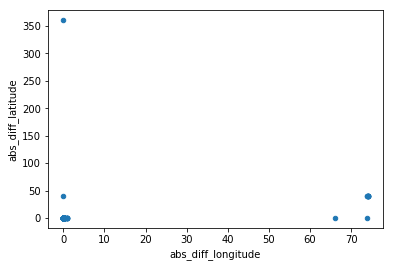

In [26]:
plot = train_df.iloc[:10000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city.  For reference, one degree of latitude is about 69 miles.  However, we can see the dataset has extreme values which do not make sense.  Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 10,000 rows...)

In [27]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999931
New size: 9979187


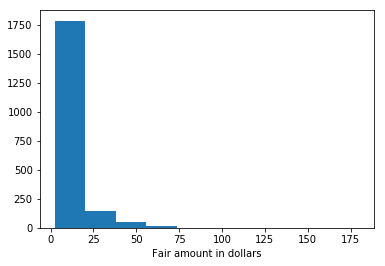

In [28]:
#analyzing the distribution of `Fair amount`
plt.hist(train_df['fare_amount'][:2000])

plt.xlabel('Fair amount in dollars')
plt.show()

The fair price distribution looks Right-skewed with majority of rides having price between dollars 2 and 20. Let's see if pickup datetime has any correlation with the fair price.  

### Train our model
First let's setup our input matrix $X$ and target column $y$ from our data.  The matrix $X$ should consist of the features that are significant in predicting the output which is Fair Price. The column $y$ should consist of the target `fare_amount` values.

In [29]:
train_df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'abs_diff_longitude', 'abs_diff_latitude'],
      dtype='object')

In [30]:
#Write a function to get the columns that we want to include in our X matrix as we would be doing the same with our test set.
def get_input_matrix(df):
    return np.column_stack((df.pickup_longitude, df.abs_diff_longitude, df.abs_diff_latitude, df.passenger_count, 
                            df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude))

X = get_input_matrix(train_df)
Y = np.array(train_df['fare_amount'])

print(X.shape)
print(Y.shape)

(9979187, 7)
(9979187,)


In [31]:
#Divide our data into train and validation set. We will be using validation set to tune the hyperparameters of the model. 
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.005, random_state=0)

print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(9929291, 7)
(49896, 7)
(9929291,)
(49896,)


In [32]:
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.03, 0.1]
for learning_rate in learning_rates:
    gb = GradientBoostingRegressor(n_estimators = 10, learning_rate = learning_rate, max_depth = 6, random_state = 0)
    gb.fit(X_train, Y_train)
    pred_train = gb.predict(X_train)
    pred_validation = gb.predict(X_validation)
    print("Learning rate: ", learning_rate)
    print("RMSE (training): {0:.3f}".format(np.sqrt(mean_squared_error(Y_train, pred_train))))
    print("RMSE (validation): {0:.3f}".format(np.sqrt(mean_squared_error(Y_validation, pred_validation))))
    print()

Learning rate:  0.03
RMSE (training): 7.912
RMSE (validation): 8.008

Learning rate:  0.1
RMSE (training): 5.611
RMSE (validation): 5.720



In [271]:
#Let's use the learning rate as 0.1 which works best for our model from the RSME on our validation set above
gb = GradientBoostingRegressor(n_estimators = 10, learning_rate = 0.1, max_depth = 6, random_state = 0)
gb.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [33]:
#let's see what are the significant features in predicting our output
gb.feature_importances_

array([7.11044223e-03, 7.41415138e-01, 2.11427550e-01, 7.62252201e-06,
       1.92054865e-03, 2.98962472e-02, 8.22245142e-03])

### Make predictions on the test set
Now let's load up our test inputs and predict the `fare_amount`s for them using our learned weights!

In [35]:
test_df = pd.read_csv('/Users/hthakkar/Desktop/pred/test.csv')
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [36]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)
test_y_predictions = gb.predict(test_X)

In [37]:
# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission31st.csv', index = False)

print(os.listdir('/Users/hthakkar/Desktop/pred'))

['.DS_Store', 'test.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv']


## Ideas for Improvement
The output here will score an RMSE of $4.8, which shows that our model has a high bias, but we can do better than that!  Here are some suggestions:

* Try training bigger model, train longer, or try using a Neural Network architecture.
* Use absolute location data rather than relative.  Here we're only looking at the difference between the start and end points, but maybe the actual values -- indicating where in NYC the taxi is traveling -- would be useful.
* Try to find more outliers to prune, or construct useful feature crosses.
* Use the entire dataset -- here we're only using about 60% of the training data!